# Univariate Density Estimation using Models Implemented in Python

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
from pybmix.core.mixing import PythonMixing
from pybmix.core.hierarchy import PythonHierarchy
from pybmix.core.mixture_model import MixtureModel
from pybmix.estimators.density_estimator import DensityEstimator

In [2]:
np.random.seed(2022)

## Generate data as mixture of two Normals

$$
y_i \sim \frac{7}{10} \mathcal N(-3, 1) + \frac{3}{10} \mathcal N(3, 1), \quad i=1, \ldots, 200
$$

In [3]:
def sample_from_mixture_norm(weights, means, sds, n_data):
    n_comp = len(weights)
    clus_alloc = np.random.choice(np.arange(n_comp), p=weights, size=n_data)
    return np.random.normal(loc=means[clus_alloc], scale=sds[clus_alloc])

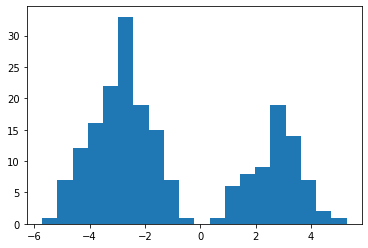

In [4]:
y_norm = sample_from_mixture_norm(
    np.array([0.7, 0.3]), np.array([-3, 3]), np.array([1, 1]), 200)
plt.hist(y_norm, bins=20)
plt.show()

## The statistical model

We assume the following model

\begin{equation}
\begin{aligned}
y_i | \tilde{p} &\sim f(\cdot) = \int_{R \times R^+} \mathcal{Laplace}(\cdot | \mu, \lambda ) \tilde{p}(d\mu, d\lambda) \\
\tilde{p} &\sim DP(\alpha, G_0)
\end{aligned}
\end{equation}

Here, we assume that $\alpha = 5$ and $G_0(d\mu, d\lambda) = \mathcal N(d\mu | \mu_0, \sigma_0^2) \times IG(d\sigma^2 | \nu_0, \psi_0)$, i.e., $G_0$ is a normal-inverse gamma distribution.

"LapNIG_Hierarchy" is implemented in a .py file and here it is passed as argument to the generic PythonHierarchy object.

Below we compare the performances of Laplace-NIG and Normal-NIG models. Please refer to "Univariate Density Estimation via Dirichlet Process Mixture" for the mathematical description of the Normal-NIG model.

In [5]:
mixing = PythonMixing("DP_mixing")
hierarchy_lapnig = PythonHierarchy("LapNIG_Hierarchy")
hierarchy_nnig_ngg = PythonHierarchy("NNIG_Hierarchy_NGG")

In [6]:
mixture_lapnig = MixtureModel(mixing, hierarchy_lapnig)
mixture_nnig_ngg = MixtureModel(mixing, hierarchy_nnig_ngg)

In [7]:
niter = 300
nburn = 100

In [8]:
mixture_lapnig.run_mcmc(y_norm, algorithm="Neal8", niter=niter, nburn=nburn)

Using hierarchy implementation in LapNIG_Hierarchy.py
Using mixing implementation in: DP_mixing.py
Initializing... Done
Running Neal8 algorithm (m=3 aux. blocks) with PythonHier hierarchies, PythonMix mixing...
===================>                                      ] 35% 61.164s[=====================>                                      ] 36% 62.269s[======================>                                     ] 36% 63.373s[======================>                                     ] 37% 64.434s[======================>                                     ] 37% 65.537s[=======================>                                    ] 38% 66.698s[=======================>                                    ] 39% 67.833s[========================>                                   ] 40% 68.935s[========================>                                   ] 40% 69.995s[========================>                                   ] 41% 71.024s[=========================>                         

In [9]:
mixture_nnig_ngg.run_mcmc(y_norm, algorithm="Neal2", niter=niter, nburn=nburn)

Using hierarchy implementation in NNIG_Hierarchy_NGG.py
Initializing... Using mixing implementation in: DP_mixing.py
Done
Running Neal2 algorithm with PythonHier hierarchies, PythonMix mixing...
========>                                                  ] 16% 12.694s[==========>                                                 ] 17% 13.026s[==========>                                                 ] 17% 13.308s[===========>                                                ] 18% 13.667s[===========>                                                ] 18% 13.973s[===========>                                                ] 19% 14.255s[============>                                               ] 20% 14.515s[============>                                               ] 20% 14.827s[=============>                                              ] 21% 15.182s[=============>                                              ] 22% 15.548s[=============>                                              ] 23% 

In [10]:
grid = np.linspace(-8, 8, 200)
dens_est_lapnig = DensityEstimator(mixture_lapnig)
densities_lapnig = dens_est_lapnig.estimate_density(grid)

=================>                                          ] 28% 15.978s[==================>                                         ] 30% 16.505s[==================>                                         ] 31% 17.214s[===================>                                        ] 33% 17.982s[====================>                                       ] 34% 18.669s[=====================>                                      ] 36% 19.43s[======================>                                     ] 37% 20.172s[=======================>                                    ] 38% 20.775s[========================>                                   ] 40% 21.589s[=========================>                                  ] 42% 22.722s[==========================>                                 ] 43% 23.416s[===========================>                                ] 45% 24.062s[============================>                               ] 47% 25.348s[==============================>        

In [11]:
dens_est_nnig_ngg = DensityEstimator(mixture_nnig_ngg)
densities_nnig_ngg = dens_est_nnig_ngg.estimate_density(grid)

[============================================================] 100% 38.508s====================>                                       ] 33% 11.811s[====================>                                       ] 34% 12.27s[=====================>                                      ] 35% 12.692s[=====================>                                      ] 36% 13.141s[======================>                                     ] 37% 13.456s[=======================>                                    ] 38% 13.815s[=======================>                                    ] 39% 14.108s[========================>                                   ] 40% 14.477s[========================>                                   ] 41% 14.874s[=========================>                                  ] 42% 15.245s[==========================>                                 ] 43% 15.73s[==========================>                                 ] 44% 16.217s[===========================>           

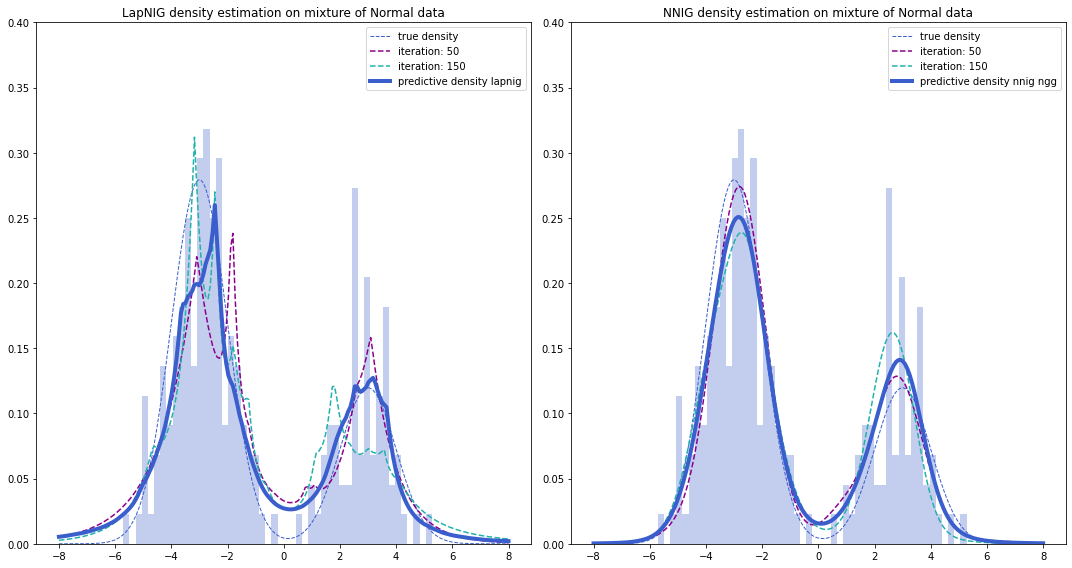

In [28]:
fig, axes = plt.subplots(1,2, figsize=(15,8))

axes[0].set_ylim(0, 0.4)
axes[1].set_ylim(0, 0.4)

axes[0].hist(y_norm, density=True, bins=50, alpha=0.3, color="#3A5FCD")
axes[0].plot(np.linspace(-8, 8, 1000), 0.7*ss.norm.pdf(np.linspace(-8, 8, 1000), -3, 1) + 0.3*ss.norm.pdf(np.linspace(-8, 8, 1000), 3, 1),
             "--", lw=1, color="#3A5FCD", label="true density")
axes[1].hist(y_norm, density=True, bins=50, alpha=0.3, color="#3A5FCD")
axes[1].plot(np.linspace(-8, 8, 1000), 0.7*ss.norm.pdf(np.linspace(-8, 8, 1000), -3, 1) + 0.3*ss.norm.pdf(np.linspace(-8, 8, 1000), 3, 1),
             "--", lw=1, color="#3A5FCD", label="true density")

idxs = [int((niter - nburn) * 0.25), int((niter - nburn) * 0.75)]
colors = ["#8B008B", "#20B2AA"]
for i, idx in enumerate(idxs):
    axes[0].plot(grid, densities_lapnig[idx, :], "--", label="iteration: {0}".format(idx), color = colors[i])
    axes[1].plot(grid, densities_nnig_ngg[idx, :], "--", label="iteration: {0}".format(idx), color = colors[i])
    
axes[0].plot(grid, np.mean(densities_lapnig, axis=0), lw=4, label="predictive density lapnig", color="#3A5FCD")
axes[1].plot(grid, np.mean(densities_nnig_ngg, axis=0), lw=4, label="predictive density nnig ngg", color="#3A5FCD")

axes[0].legend()
axes[1].legend()

axes[0].set_title("LapNIG density estimation on mixture of Normal data")
axes[1].set_title("NNIG density estimation on mixture of Normal data")

plt.tight_layout()
plt.show()

## Generate data as mixture of two Laplace


Let us now repeat the procedure with data sampled from a mixture of Laplace 
$$
y_i \sim \frac{7}{10} \mathcal Laplace(-3, 1) + \frac{3}{10} \mathcal Laplace(3, 1), \quad i=1, \ldots, 200
$$

In [13]:
np.random.seed(2022)

In [14]:
def sample_from_mixture_lap(weights, means, sds, n_data):
    n_comp = len(weights)
    clus_alloc = np.random.choice(np.arange(n_comp), p=weights, size=n_data)
    return np.random.laplace(loc=means[clus_alloc], scale=sds[clus_alloc])

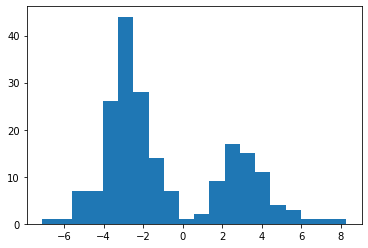

In [15]:
y_lap = sample_from_mixture_lap(
    np.array([0.7, 0.3]), np.array([-3, 3]), np.array([1, 1]), 200)
plt.hist(y_lap, bins=20)
plt.show()

In [16]:
mixture_lapnig_2 = MixtureModel(mixing, hierarchy_lapnig)
mixture_nnig_ngg_2 = MixtureModel(mixing, hierarchy_nnig_ngg)

In [17]:
niter = 300
nburn = 100

In [18]:
mixture_lapnig_2.run_mcmc(y_lap, algorithm="Neal8", niter=niter, nburn=nburn)

Initializing... Using hierarchy implementation in LapNIG_Hierarchy.py
Using mixing implementation in: DP_mixing.py
Done
Running Neal8 algorithm (m=3 aux. blocks) with PythonHier hierarchies, PythonMix mixing...
===========>                                               ] 20% 36.928s[=============>                                              ] 21% 37.928s[=============>                                              ] 22% 38.907s[=============>                                              ] 23% 40.025s[==============>                                             ] 23% 41.16s[==============>                                             ] 24% 42.388s[===============>                                            ] 25% 43.604s[===============>                                            ] 25% 44.946s[===============>                                            ] 26% 46.269s[================>                                           ] 27% 47.381s[================>                                  

In [19]:
mixture_nnig_ngg_2.run_mcmc(y_lap, algorithm="Neal2", niter=niter, nburn=nburn)

Initializing... Using hierarchy implementation in NNIG_Hierarchy_NGG.py
Using mixing implementation in: DP_mixing.py
Done
Running Neal2 algorithm with PythonHier hierarchies, PythonMix mixing...
=========>                                                 ] 16% 16.117s[==========>                                                 ] 17% 16.679s[==========>                                                 ] 18% 17.104s[===========>                                                ] 18% 17.513s[===========>                                                ] 19% 17.928s[============>                                               ] 20% 18.456s[============>                                               ] 20% 18.989s[============>                                               ] 21% 19.432s[=============>                                              ] 21% 19.894s[=============>                                              ] 22% 20.394s[==============>                                             ] 23% 

In [20]:
grid = np.linspace(-8, 8, 200)
dens_est_lapnig_2 = DensityEstimator(mixture_lapnig_2)
densities_lapnig_2 = dens_est_lapnig_2.estimate_density(grid)

[============================================================] 100% 62.789s                                                          ] 1% 1.15s[==>                                                         ] 3% 1.963s[==>                                                         ] 4% 2.461s[===>                                                        ] 5% 3.06s[===>                                                        ] 6% 3.732s[====>                                                       ] 7% 4.695s[=====>                                                      ] 9% 5.668s[======>                                                     ] 10% 6.133s[======>                                                     ] 11% 6.655s[=======>                                                    ] 12% 7.151s[========>                                                   ] 13% 7.704s[========>                                                   ] 14% 8.38s[=========>                                                  ]

In [21]:
dens_est_nnig_ngg_2 = DensityEstimator(mixture_nnig_ngg_2)
densities_nnig_ngg_2 = dens_est_nnig_ngg_2.estimate_density(grid)

[============================================================] 100% 45.737s
Done


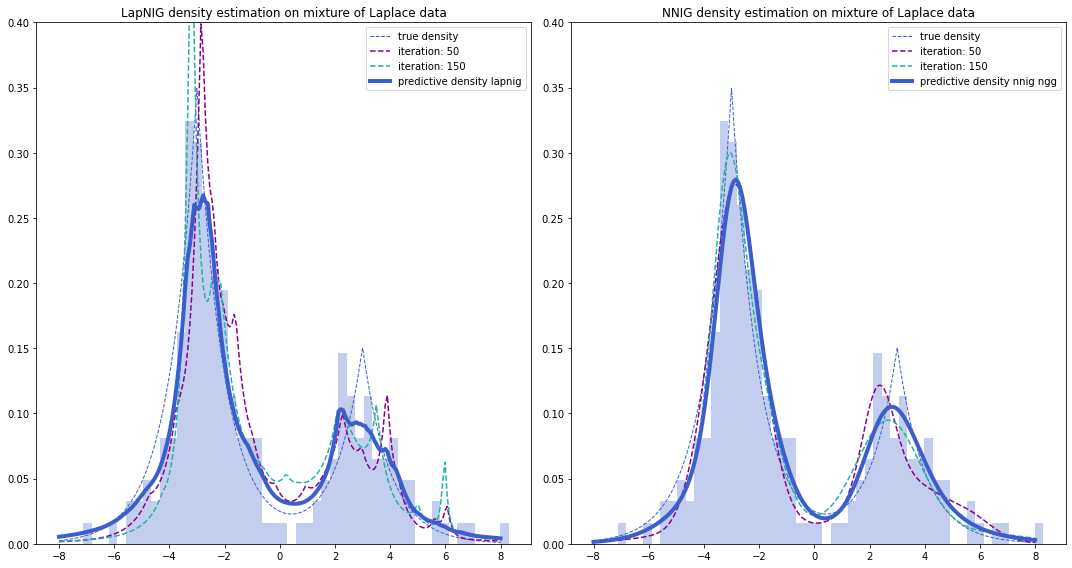

In [29]:
fig, axes = plt.subplots(1,2, figsize=(15,8))

axes[0].set_ylim(0, 0.4)
axes[1].set_ylim(0, 0.4)

axes[0].hist(y_lap, density=True, bins=50, alpha=0.3, color="#3A5FCD")
axes[0].plot(np.linspace(-8, 8, 1000), 0.7*ss.laplace.pdf(np.linspace(-8, 8, 1000), -3, 1) + 0.3*ss.laplace.pdf(np.linspace(-8, 8, 1000), 3, 1),
             "--", lw=1, color="#3A5FCD", label="true density")
axes[1].hist(y_lap, density=True, bins=50, alpha=0.3, color="#3A5FCD")
axes[1].plot(np.linspace(-8, 8, 1000), 0.7*ss.laplace.pdf(np.linspace(-8, 8, 1000), -3, 1) + 0.3*ss.laplace.pdf(np.linspace(-8, 8, 1000), 3, 1),
             "--", lw=1, color="#3A5FCD", label="true density")

idxs = [int((niter - nburn) * 0.25), int((niter - nburn) * 0.75)]
colors = ["#8B008B", "#20B2AA"]
for i, idx in enumerate(idxs):
    axes[0].plot(grid, densities_lapnig_2[idx, :], "--", label="iteration: {0}".format(idx), color = colors[i])
    axes[1].plot(grid, densities_nnig_ngg_2[idx, :], "--", label="iteration: {0}".format(idx), color = colors[i])
    
axes[0].plot(grid, np.mean(densities_lapnig_2, axis=0), lw=4, label="predictive density lapnig", color="#3A5FCD")
axes[1].plot(grid, np.mean(densities_nnig_ngg_2, axis=0), lw=4, label="predictive density nnig ngg", color="#3A5FCD")

axes[0].legend()
axes[1].legend()

axes[0].set_title("LapNIG density estimation on mixture of Laplace data")
axes[1].set_title("NNIG density estimation on mixture of Laplace data")

plt.tight_layout()
plt.show()